# Load Pretrained weights into Resnet Model

In [1]:
from importlib.util import find_spec
if find_spec("model") is None:
    import sys
    sys.path.append('..')

In [11]:
from torchvision.models import resnet50

In [3]:
from model.backbone.resnet import ResNet50

In [4]:
pretrained_model = resnet50(pretrained=True)

In [5]:
model = ResNet50(num_classes=1000)

In [6]:
len(model.state_dict().items())

320

In [7]:
len(pretrained_model.state_dict().items())

320

In [8]:
new = list(pretrained_model.state_dict().items())

In [9]:
model_dict = model.state_dict()
count = 0
for k, v in model_dict.items():
    layer_name, weights = new[count]
    model_dict[k] = weights
    count += 1

In [4]:
model = ResNet50(pretrained=True)

## Test Model Loading with FastAI Pets dataset

Following [FastAI Walk CoLab](https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/01_Pets.ipynb#scrollTo=_85VW_jT3gJk)

In [3]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [4]:
path = untar_data(URLs.PETS)

In [5]:
np.random.seed(2)

In [6]:
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

In [7]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1., 1.))
bs = 64

### Using Highest Level API

In [8]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, item_tfms=item_tfms, bs=bs)

### Using Medium Level API

In [15]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat=pat),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms
                )

In [16]:
path_im = path/'images'

In [17]:
dls = pets.dataloaders(path_im, bs=bs)

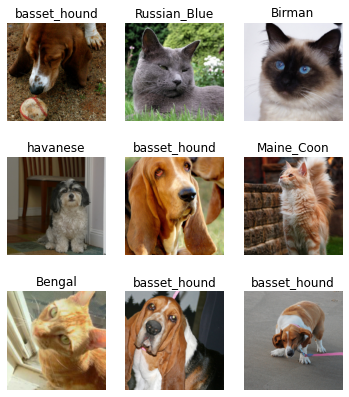

In [10]:
dls.show_batch(max_n=9, figsize=(6,7))

In [19]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,3.885445,5.139984,00:40
1,3.426958,3.457565,00:38
2,2.999181,2.856734,00:38
3,2.527288,2.563837,00:38


../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=1.3182567499825382e-06)

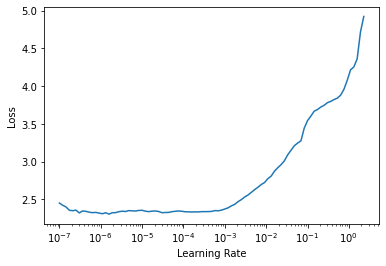

In [21]:
learn.lr_find()

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(4, 1.32e-6)

epoch,train_loss,valid_loss,time
0,2.346809,2.564211,00:37
1,2.321156,2.550872,00:37
2,2.325650,2.529191,00:38
3,2.321846,2.539825,00:37


../model/backbone/resnet.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.fc(out))


### Build Custom Model for Pets Model

Following [Fast AI Tutorial](https://docs.fast.ai/tutorial.siamese)

In [9]:
class PetsModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
        
    def forward(self, x):
        return self.head(self.encoder(x))

In [11]:
encoder = create_body(ResNet50, cut=-2)

In [12]:
encoder[-1]

Sequential(
  (0): BottleNeckBlock(
    (block): Sequential(
      (0): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (shortcut): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BottleNeckBlock(
    (block): Sequential(
      (0): Conv2d(2048, 512, kernel_siz

In [13]:
len(encoder.state_dict().items())

318

In [14]:
head = create_head(2048 * 2, 37, ps=0.5)
model = PetsModel(encoder, head)

In [15]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

In [16]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [17]:
learn.freeze()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.00010964782268274575)

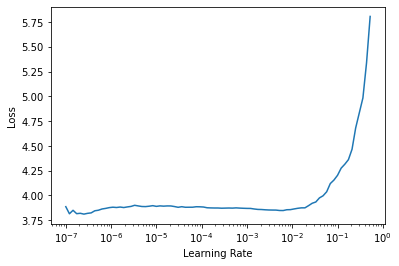

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 6e-4)

epoch,train_loss,valid_loss,time
0,3.715457,3.672529,00:38
1,3.493899,3.473586,00:38
2,3.317317,3.179959,00:38
3,3.120512,3.071259,00:38


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.3182567499825382e-06)

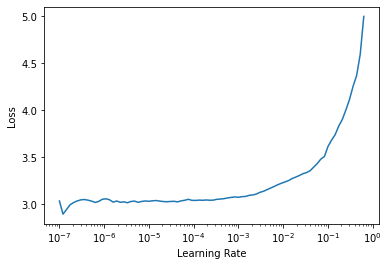

In [20]:
learn.lr_find()

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

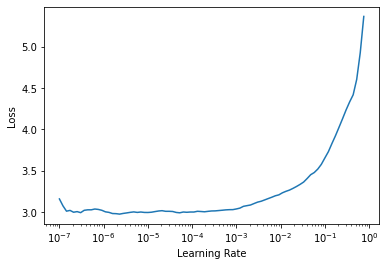

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,time
0,3.048825,3.063633,00:38
1,3.034108,2.953416,00:38
2,2.860962,2.809908,00:38
3,2.737015,2.779896,00:38


### Using Pytorch ResNet50 Model

In [12]:
import torchvision.models as models

In [13]:
encoder = create_body(models.resnet50, cut=-2)

In [14]:
encoder[-1]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [15]:
head = create_head(2048 * 2, 37)
model = PetsModel(encoder, head)

In [16]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss())

In [17]:
learn.freeze()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0002754228771664202)

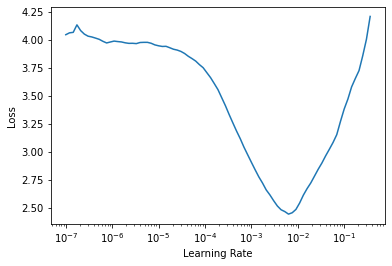

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, 2e-4)

epoch,train_loss,valid_loss,time
0,1.151343,0.457354,00:37
1,0.426457,0.293306,00:37
2,0.200066,0.212478,00:38
3,0.091453,0.189916,00:37
